In [ ]:
import numpy as np
from numba import njit, prange

## Functions

In [7]:
@njit(nopython=True)
def relu(z):
    return np.maximum(0, z)

@njit(nopython=True)
def relu_prime(z):
    return (z > 0).astype(np.float64)

@njit(nopython=True)
def softmax(z):
    # z shape: (n, 1)
    max_z = np.max(z)
    exp_z = np.exp(z - max_z)
    return exp_z / np.sum(exp_z)

@njit(nopython=True)
def softmax_prime(z):
    s = softmax(z)
    return s * (1 - s)
    
@njit(nopython=True)
def cross_entropy(y_pred, y):
    m = y.shape[1]
    return -np.sum(y * np.log(y_pred + 1e-9)) / m
    
@njit(nopython=True)
def cross_entropy_prime(y_pred, y):
    return y_pred - y

C:\Users\santt\anaconda3\Lib\site-packages\numba\core\decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


## Layer class helper functions

In [10]:
@njit(nopython=True, parallel=True)
def conv_forward_numba(X, W, b, stride):
    H, W_in, C = X.shape
    F, K_h, K_w, _ = W.shape
    H_out = (H - K_h) // stride + 1
    W_out = (W_in - K_w) // stride + 1
    a = np.zeros((H_out, W_out, F))
    z = np.zeros((H_out, W_out, F))
    for f in prange(F):
        for i in prange(H_out):
            for j in prange(W_out):
                i0 = i * stride
                j0 = j * stride
                region = X[i0:i0+K_h, j0:j0+K_w, :]
                z_val = np.sum(region * W[f]) + b[f, 0]
                z[i, j, f] = z_val
                a[i, j, f] = relu(z_val)
    return a, z

@njit(nopython=True, parallel=True)
def conv_backward_numba(X, W, dZ, stride):
    H, W_in, C = X.shape
    F, K_h, K_w, _ = W.shape
    H_out, W_out, _ = dZ.shape
    dW = np.zeros_like(W)
    db = np.zeros((F, 1))
    dX = np.zeros_like(X)
    for f in prange(F):
        db[f, 0] = np.sum(dZ[:, :, f])
        for i in prange(H_out):
            for j in prange(W_out):
                i0 = i * stride
                j0 = j * stride
                region = X[i0:i0+K_h, j0:j0+K_w, :]
                grad = dZ[i, j, f]
                dW[f] += region * grad
                dX[i0:i0+K_h, j0:j0+K_w, :] += W[f] * grad
    return dX, dW, db

# Numba-accelerated maxpool forward/backward
@njit(nopython=True, parallel=True)
def maxpool_forward_numba(X, K_h, K_w, stride):
    H, W_in, C = X.shape
    H_out = (H - K_h) // stride + 1
    W_out = (W_in - K_w) // stride + 1
    a = np.zeros((H_out, W_out, C))
    idx = np.empty((H_out, W_out, C, 2), np.int64)
    for c in prange(C):
        for i in range(H_out):
            for j in range(W_out):
                i0 = i * stride
                j0 = j * stride
                region = X[i0:i0+K_h, j0:j0+K_w, c]
                # find max position
                max_idx = np.argmax(region)
                mi = max_idx // K_w
                mj = max_idx % K_w
                a[i, j, c] = region[mi, mj]
                idx[i, j, c, 0] = i0 + mi
                idx[i, j, c, 1] = j0 + mj
    return a, idx

@njit(nopython=True, parallel=True)
def maxpool_backward_numba(dA, idx, H, W_in, C):
    dX = np.zeros((H, W_in, C))
    H_out, W_out = dA.shape[0], dA.shape[1]
    for c in prange(C):
        for i in range(H_out):
            for j in range(W_out):
                pi = idx[i, j, c, 0]
                pj = idx[i, j, c, 1]
                dX[pi, pj, c] = dA[i, j, c]
    return dX

## Layer classes

In [13]:
class Dense:
    def __init__(self, input_size, layer_size, activation, init=None):
        self.input_size = input_size
        self.layer_size = layer_size
        self.a_func = activation
        if init == 'he':
            std = np.sqrt(2. / input_size)
            self.weights = np.random.randn(layer_size, input_size) * std
            self.biases = np.zeros((layer_size, 1))
        else:
            self.weights = np.random.randn(layer_size, input_size)
            self.biases = np.random.randn(layer_size, 1)

    def forward(self, X):
        self.X = X
        self.z = self.weights @ X + self.biases
        self.a = self.a_func[0](self.z)
        return self.a

    def backward(self, dA):
        dz = dA * self.a_func[1](self.z)
        self.dW = dz @ self.X.T
        self.db = dz
        return self.weights.T @ dz

class Conv:
    def __init__(self, input_size, activation, kernel_size, num_filters=1, stride=1, padding=0, init=None):
        h, w, c = (list(input_size) + [1,1,1])[:3]
        self.input_size = (h, w, c)
        self.a_func = activation
        self.kernel_size = (*kernel_size, c)
        self.num_filters = num_filters
        self.stride = stride
        if init == 'he':
            fan = kernel_size[0]*kernel_size[1]*c
            std = np.sqrt(2./fan)
            self.weights = np.random.randn(num_filters, *self.kernel_size) * std
            self.biases = np.zeros((num_filters,1))
        else:
            self.weights = np.random.randn(num_filters, *self.kernel_size)
            self.biases = np.random.randn(num_filters,1)

    def forward(self, X):
        self.X = X
        a, z = conv_forward_numba(X, self.weights, self.biases, self.stride)
        self.z = z
        self.a = self.a_func[0](a)
        return self.a

    def backward(self, dA):
        dZ = dA * self.a_func[1](self.z)
        dX, dW, db = conv_backward_numba(self.X, self.weights, dZ, self.stride)
        self.dW = dW
        self.db = db
        return dX

class MaxPool:
    def __init__(self, input_size, kernel_size, stride=1):
        h, w, c = (list(input_size) + [1,1,1])[:3]
        self.input_size = (h, w, c)
        self.kernel_size = (*kernel_size, c)
        self.stride = stride

    def forward(self, X):
        self.X = X
        a, idx = maxpool_forward_numba(X, self.kernel_size[0], self.kernel_size[1], self.stride)
        self.a = a
        self.idx = idx
        return self.a

    def backward(self, dA):
        H, W_in, C = self.X.shape
        return maxpool_backward_numba(dA, self.idx, H, W_in, C)

class Flatten:
    def forward(self, X):
        # Just reshapes
        self.input_shape = X.shape
        return X.reshape(-1,1)

    def backward(self, dA):
        return dA.reshape(self.input_shape)

## Neural network class

In [16]:
class NeuralNetwork:
    def __init__(self, layers, cost=None):
        self.layers = layers
        self.cost = cost

    def forward(self, X):
        a = X
        for layer in self.layers:
            a = layer.forward(a)
        self.output = a
        return a

    def backprop(self, y):
        dA = self.cost[1](self.output, y.reshape(-1,1))
        for layer in reversed(self.layers):
            dA = layer.backward(dA)

    def init_velocity(self):
        for layer in self.layers:
            if hasattr(layer, 'weights'):
                layer.vW = np.zeros_like(layer.weights)
                layer.vb = np.zeros_like(layer.biases)

    def update_wb(self, eta, batch_size):
        for layer in self.layers:
            if hasattr(layer, 'dW'):
                layer.weights -= eta * (layer.dW / batch_size)
                layer.biases  -= eta * (layer.db / batch_size)

    def update_wb_momentum(self, eta, momentum, batch_size):
        for layer in self.layers:
            if hasattr(layer, 'dW'):
                layer.vW = momentum * layer.vW + eta * (layer.dW / batch_size)
                layer.vb = momentum * layer.vb + eta * (layer.db / batch_size)
                
                layer.weights -= layer.vW
                layer.biases -= layer.vb
                

    def train(self, x_train, y_train, epochs, batch_size, lr, momentum=None, decay=1, decay_step=1, results=False, print_every=10):
        num_samples = len(x_train)
        eta = lr

        if momentum is not None:
            self.init_velocity()
        
        for epoch in range(epochs):
            indices = np.random.permutation(num_samples)
            X_shuffled = [x_train[i] for i in indices]
            y_shuffled = [y_train[i] for i in indices]

            if results:
                epoch_outputs, epoch_labels = [], []

            batch_count = 0
            for i in range(0, num_samples, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]

                # Zero gradients
                for layer in self.layers:
                    if hasattr(layer, 'dW'):
                        layer.dW = np.zeros_like(layer.weights)
                        layer.db = np.zeros_like(layer.biases)

                if results:
                    batch_outputs, batch_labels = [], []

                for x, y in zip(X_batch, y_batch):
                    out = self.forward(x)
                    self.backprop(y)

                    if results:
                        batch_outputs.append(out.flatten())
                        batch_labels.append(y.flatten())
                        epoch_outputs.append(out.flatten())
                        epoch_labels.append(y.flatten())

                if momentum is not None:
                    self.update_wb_momentum(eta, momentum, len(X_batch))
                else:
                    self.update_wb(eta, len(X_batch))
                batch_count += 1

                if results and (batch_count % print_every == 0):
                    batch_outputs = np.array(batch_outputs)
                    batch_labels = np.array(batch_labels)
                    batch_loss = self.cost[0](batch_outputs, batch_labels)
                    batch_preds = np.argmax(batch_outputs, axis=1)
                    batch_true = np.argmax(batch_labels, axis=1)
                    batch_acc = np.mean(batch_preds == batch_true)
                    print(f"Epoch {epoch+1}, Batch {batch_count}, Loss: {batch_loss:.4f}, Accuracy: {batch_acc * 100:.2f}%")

            if (epoch+1) % decay_step == 1:
                eta = eta * decay # decay learning rate

            if results:
                epoch_outputs = np.array(epoch_outputs)
                epoch_labels = np.array(epoch_labels)
                loss = self.cost[0](epoch_outputs, epoch_labels)
                preds = np.argmax(epoch_outputs, axis=1)
                true_labels = np.argmax(epoch_labels, axis=1)
                accuracy = np.mean(preds == true_labels)
                print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}, Accuracy: {accuracy * 100:.2f}%")

## Training

### Load MNIST dataset and prepare data

In [84]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data to the range [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

alpha = 4.0  # contrast factor (>1 increases contrast, <1 decreases)
x_train = np.clip(0.5 + alpha * (x_train - 0.5), 0, 1)
x_test  = np.clip(0.5 + alpha * (x_test  - 0.5), 0, 1)

gamma = 0.7  # <1 brightens, >1 darkens
x_train = np.power(x_train, gamma)
x_test  = np.power(x_test, gamma)

# Pad images with 2 pixels of zeros on all sides: 28x28 -> 32x32
x_train = np.pad(x_train, pad_width=((0, 0), (2, 2), (2, 2)), mode='constant')
x_test = np.pad(x_test, pad_width=((0, 0), (2, 2), (2, 2)), mode='constant')

# Add channel dimension: (32, 32) -> (32, 32, 1)
x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

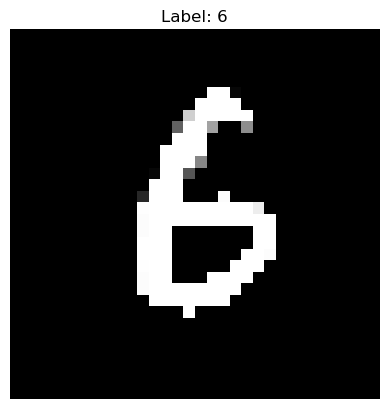

In [180]:
import matplotlib.pyplot as plt
idx = np.random.randint(0, len(x_train))   # random index
img = x_train[idx].squeeze()               # remove channel dimension
label = np.argmax(y_train[idx])            # convert one-hot back to label

plt.imshow(img, cmap="gray")
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

### Initialize neural network and train it

In [183]:
convolutional_layer = Conv((28,28,6), (relu, relu_prime), (5,5), 6)
input_data = np.random.randn(28, 28, 6)  # Example input

output = convolutional_layer.forward(input_data)
print("Output shape:", output.shape)  # Should be (26, 26, 8) for a 3x3 kernel with stride 1 and no padding

maxpool = MaxPool((24,24,6), (2,2), stride=2)
maximum = maxpool.forward(output)
maximum.shape

Output shape: (24, 24, 6)


(12, 12, 6)

In [189]:
layers = [
    Conv((32,32,1), (relu, relu_prime), (5,5), 6, init="he"),
    MaxPool((28,28,6), (2,2), stride=2),
    Conv((14,14,6), (relu, relu_prime), (5,5), 16,  init="he"),
    MaxPool((10,10,16), (2,2), stride=2),
    Flatten(),
    Dense(400, 120, (relu, relu_prime), init="he"),
    Dense(120, 100, (relu, relu_prime), init="he"),
    Dense(100, 10, (softmax, softmax_prime), init="he")
]

nn = NeuralNetwork(layers, cost=(cross_entropy, cross_entropy_prime))

nn.train(x_train, y_train, epochs=50, batch_size=64, lr=0.1, momentum=0.9, decay=0.95, decay_step=5, results=True, print_every=10)

Epoch 1, Batch 10, Loss: 15.2008, Accuracy: 18.75%
Epoch 1, Batch 20, Loss: 15.1711, Accuracy: 7.81%
Epoch 1, Batch 30, Loss: 15.3392, Accuracy: 6.25%
Epoch 1, Batch 40, Loss: 15.1066, Accuracy: 15.62%
Epoch 1, Batch 50, Loss: 14.8586, Accuracy: 18.75%
Epoch 1, Batch 60, Loss: 14.9471, Accuracy: 20.31%
Epoch 1, Batch 70, Loss: 14.1432, Accuracy: 14.06%
Epoch 1, Batch 80, Loss: 14.2761, Accuracy: 23.44%
Epoch 1, Batch 90, Loss: 14.7332, Accuracy: 10.94%
Epoch 1, Batch 100, Loss: 14.1911, Accuracy: 20.31%
Epoch 1, Batch 110, Loss: 14.0730, Accuracy: 18.75%
Epoch 1, Batch 120, Loss: 14.6894, Accuracy: 23.44%
Epoch 1, Batch 130, Loss: 13.8044, Accuracy: 17.19%
Epoch 1, Batch 140, Loss: 13.7884, Accuracy: 18.75%
Epoch 1, Batch 150, Loss: 13.3797, Accuracy: 26.56%
Epoch 1, Batch 160, Loss: 13.7714, Accuracy: 29.69%
Epoch 1, Batch 170, Loss: 13.9407, Accuracy: 17.19%
Epoch 1, Batch 180, Loss: 12.9403, Accuracy: 28.12%
Epoch 1, Batch 190, Loss: 12.8365, Accuracy: 37.50%
Epoch 1, Batch 200, Los

## Testing

Accuracy: 97.84% (9784/10000)

Correctly Classified Examples:
Network output: 
[0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 1.00, 0.00, 0.00]


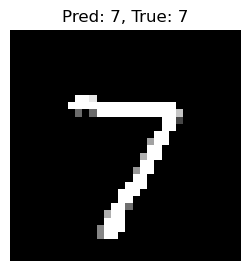


Network output: 
[0.00, 0.00, 1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]


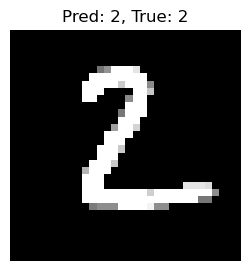


Network output: 
[0.00, 1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]


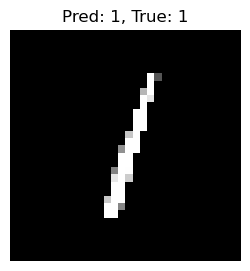


Network output: 
[1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]


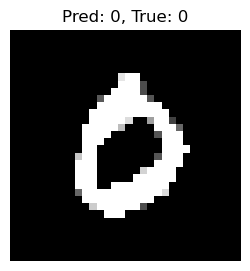


Network output: 
[0.00, 0.00, 0.00, 0.00, 1.00, 0.00, 0.00, 0.00, 0.00, 0.00]


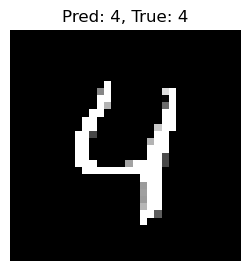




Misclassified Examples:
Network output: 
[0.00, 0.00, 0.00, 0.37, 0.00, 0.17, 0.00, 0.00, 0.45, 0.00]


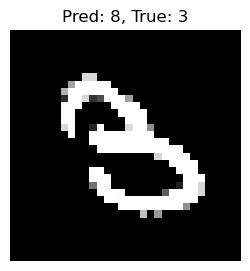


Network output: 
[0.00, 0.01, 0.79, 0.00, 0.14, 0.00, 0.06, 0.00, 0.00, 0.00]


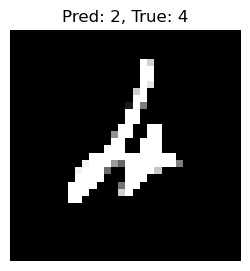


Network output: 
[0.98, 0.00, 0.00, 0.00, 0.00, 0.01, 0.01, 0.00, 0.00, 0.00]


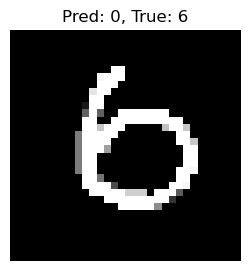


Network output: 
[0.00, 0.00, 0.00, 0.00, 0.20, 0.65, 0.01, 0.00, 0.13, 0.01]


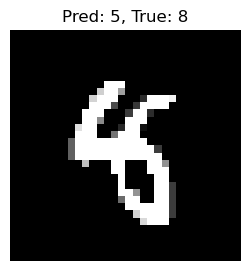


Network output: 
[0.00, 0.07, 0.00, 0.00, 0.00, 0.00, 0.00, 0.17, 0.65, 0.11]


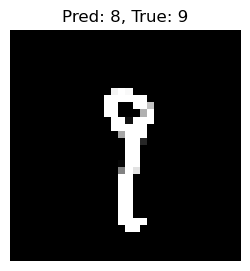


Network output: 
[0.00, 0.00, 0.08, 0.00, 0.00, 0.00, 0.00, 0.92, 0.00, 0.00]


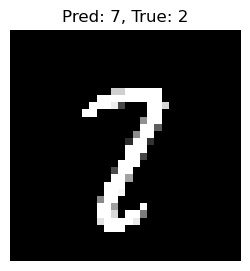


Network output: 
[0.00, 0.00, 0.00, 0.78, 0.00, 0.21, 0.01, 0.00, 0.00, 0.00]


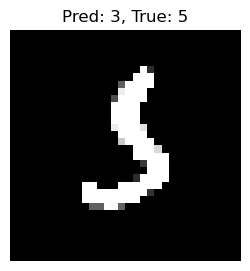


Network output: 
[0.00, 0.00, 0.00, 0.00, 0.67, 0.00, 0.00, 0.00, 0.08, 0.25]


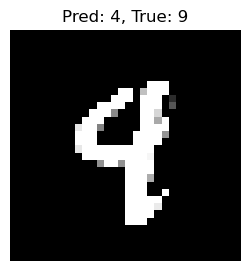


Network output: 
[0.00, 0.00, 0.00, 0.81, 0.00, 0.16, 0.00, 0.00, 0.01, 0.02]


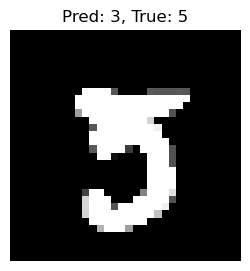


Network output: 
[0.00, 0.00, 0.00, 0.01, 0.00, 0.00, 0.00, 0.00, 0.58, 0.41]


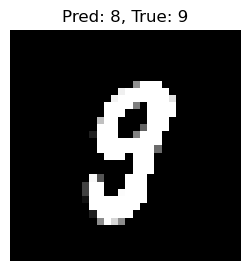


Network output: 
[0.39, 0.00, 0.15, 0.00, 0.00, 0.00, 0.13, 0.00, 0.33, 0.00]


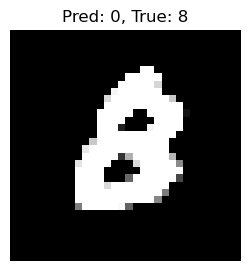


Network output: 
[0.00, 0.00, 0.98, 0.00, 0.00, 0.00, 0.00, 0.00, 0.01, 0.00]


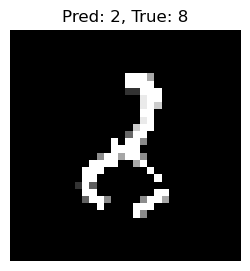


Network output: 
[0.02, 0.00, 0.49, 0.03, 0.00, 0.00, 0.00, 0.00, 0.45, 0.00]


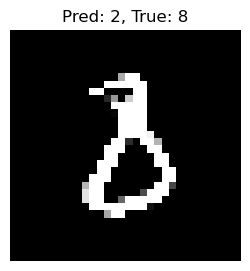


Network output: 
[0.00, 0.34, 0.14, 0.02, 0.00, 0.00, 0.00, 0.01, 0.49, 0.00]


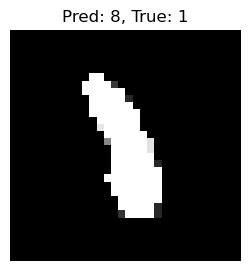


Network output: 
[0.00, 0.44, 0.02, 0.01, 0.00, 0.00, 0.00, 0.47, 0.06, 0.00]


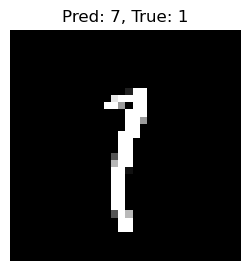


Network output: 
[0.23, 0.00, 0.03, 0.00, 0.00, 0.03, 0.70, 0.00, 0.00, 0.01]


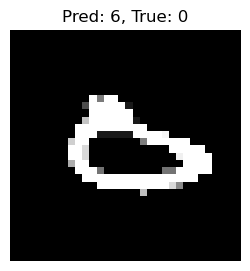


Network output: 
[0.00, 0.00, 0.00, 0.00, 0.00, 0.08, 0.00, 0.00, 0.91, 0.00]


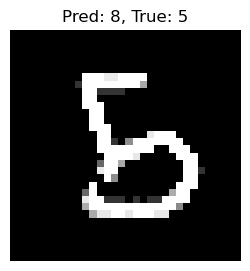


Network output: 
[0.00, 0.00, 0.00, 0.00, 0.24, 0.00, 0.00, 0.01, 0.00, 0.74]


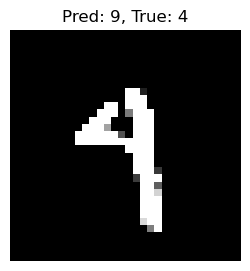


Network output: 
[0.00, 0.00, 0.79, 0.00, 0.00, 0.00, 0.00, 0.21, 0.00, 0.00]


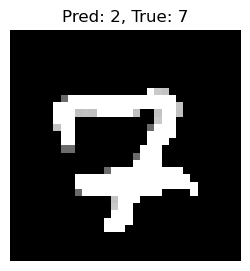


Network output: 
[0.00, 0.00, 0.00, 0.00, 0.02, 0.00, 0.00, 0.00, 0.61, 0.38]


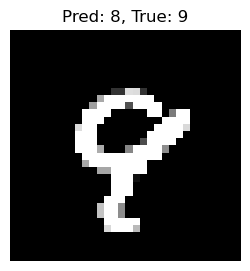


Network output: 
[0.00, 0.00, 0.00, 0.00, 0.04, 0.00, 0.00, 0.69, 0.05, 0.21]


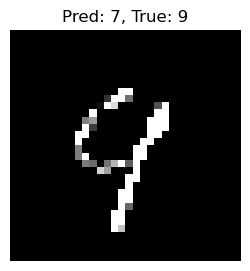


Network output: 
[0.65, 0.00, 0.31, 0.00, 0.00, 0.00, 0.00, 0.00, 0.02, 0.00]


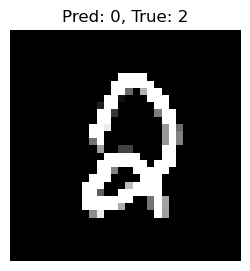


Network output: 
[0.00, 0.00, 0.00, 0.06, 0.00, 0.88, 0.00, 0.00, 0.01, 0.06]


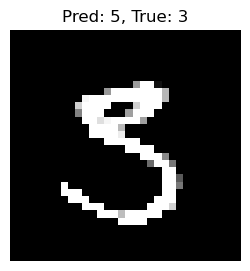


Network output: 
[0.00, 0.00, 0.00, 0.00, 0.03, 0.17, 0.00, 0.03, 0.00, 0.76]


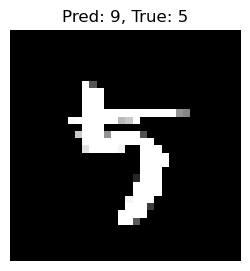


Network output: 
[0.27, 0.00, 0.01, 0.01, 0.00, 0.64, 0.06, 0.00, 0.00, 0.01]


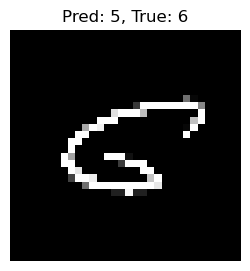

In [191]:
import matplotlib.pyplot as plt

def test_model(network, X_test, y_test, num_correct=5, num_false=5, show_examples=True):
    # Convert labels and initialize storage
    true_labels = np.argmax(y_test, axis=1)
    correct, misclassified = [], []
    all_outputs = []
    
    # Single pass through all test data
    for i in range(len(X_test)):
        x = X_test[i]
        output = network.forward(x).flatten()
        pred = np.argmax(output)
        actual = true_labels[i]
        
        # Store outputs and sort examples
        all_outputs.append(output)
        if pred == actual:
            correct.append(i)
        else:
            misclassified.append(i)
    
    # Calculate and print accuracy
    accuracy = len(correct) / len(X_test)
    print(f"Accuracy: {accuracy * 100:.2f}% ({len(correct)}/{len(X_test)})")

    if not show_examples:
        return
    
    # Helper function to show examples
    def show_examples(examples, title, num_examples):
        print(f"\n{title}:")
        for i in examples[:num_examples]:
            x = X_test[i]
            output = all_outputs[i]
            pred = np.argmax(output)
            true = true_labels[i]

            print("Network output: ")
            print(f"[{', '.join(f'{v:.2f}' for v in output)}]")
            plt.figure(figsize=(3, 3))
            plt.imshow(x, cmap='gray')
            plt.title(f"Pred: {pred}, True: {true}")
            plt.axis('off')
            plt.show()
            print()

        print("=" * 60)
        print()
    
    # Show both correct and misclassified examples
    if correct:
        show_examples(correct, "Correctly Classified Examples", num_correct)
    if misclassified:
        show_examples(misclassified, "Misclassified Examples", num_false)
        

test_model(nn, x_test, y_test, num_correct=5, num_false=25)